Simulating lead susceptibility...


C:\Users\denpr\AppData\Local\Temp\ipykernel_21912\3443476488.py:117: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  mu = fsolve(number_equation, mu_guess)[0]
C:\Users\denpr\AppData\Local\Temp\ipykernel_21912\3443476488.py:117: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  mu = fsolve(number_equation, mu_guess)[0]
C:\Users\denpr\AppData\Local\Temp\ipykernel_21912\3443476488.py:110: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should 

KeyboardInterrupt: 

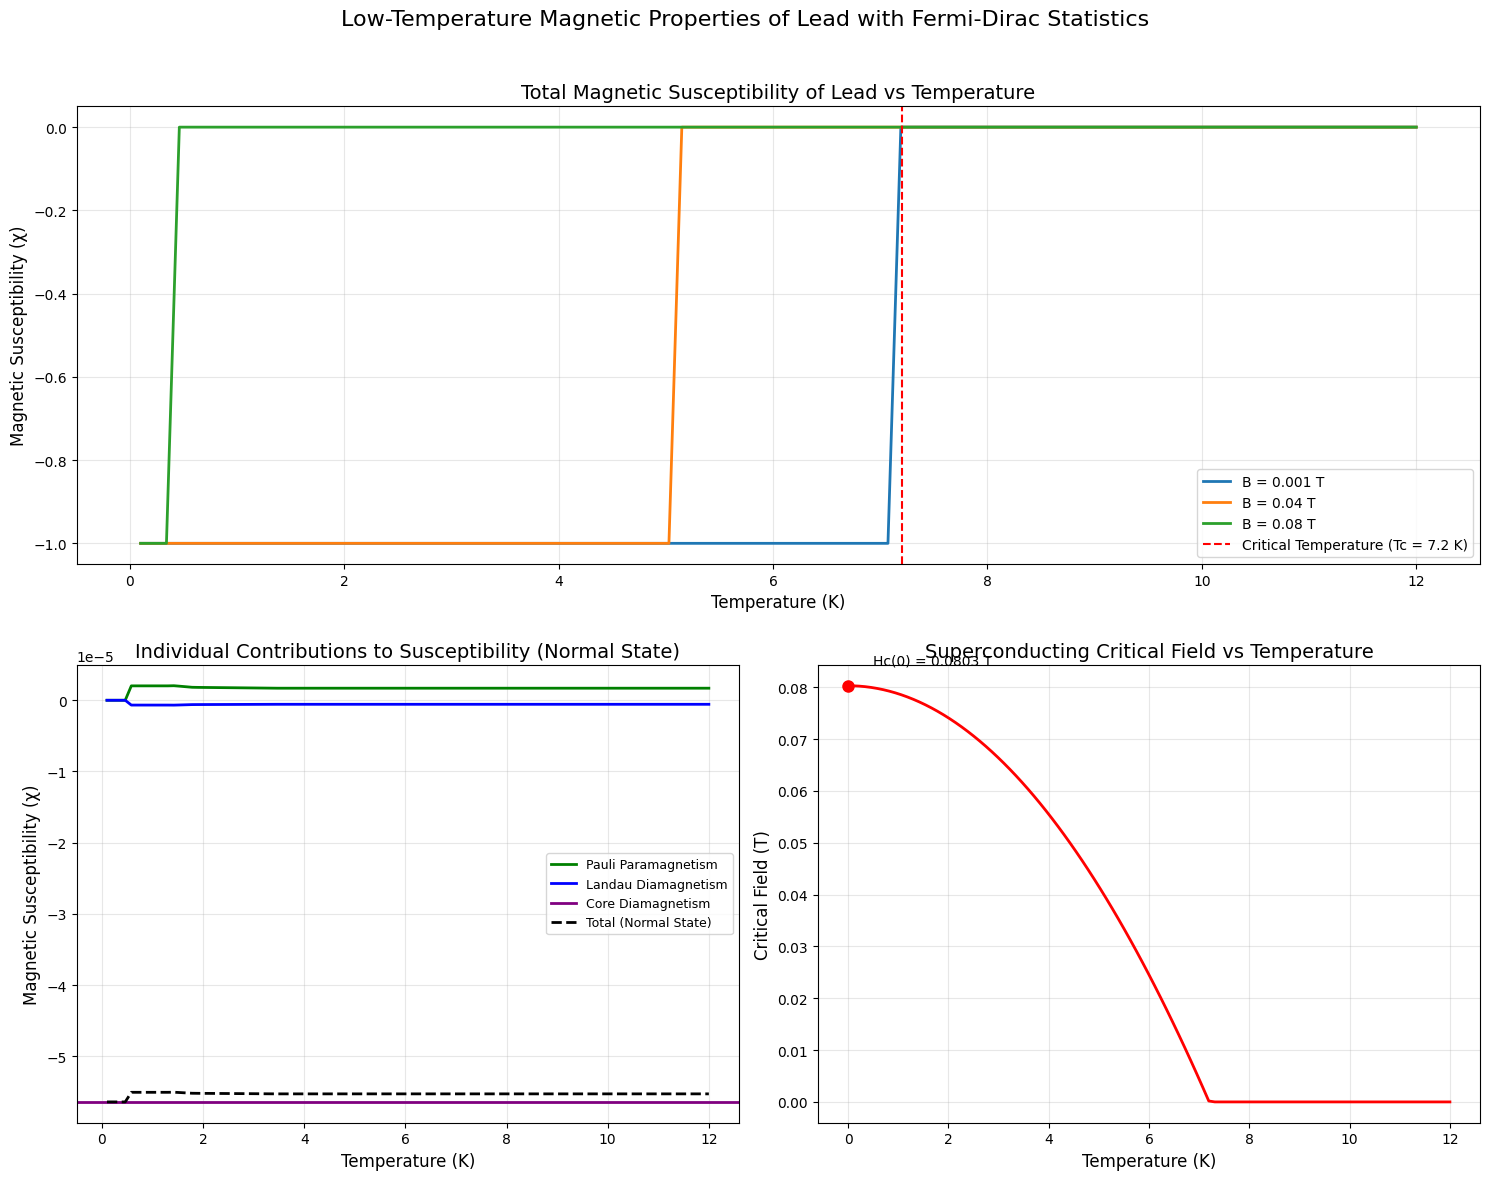

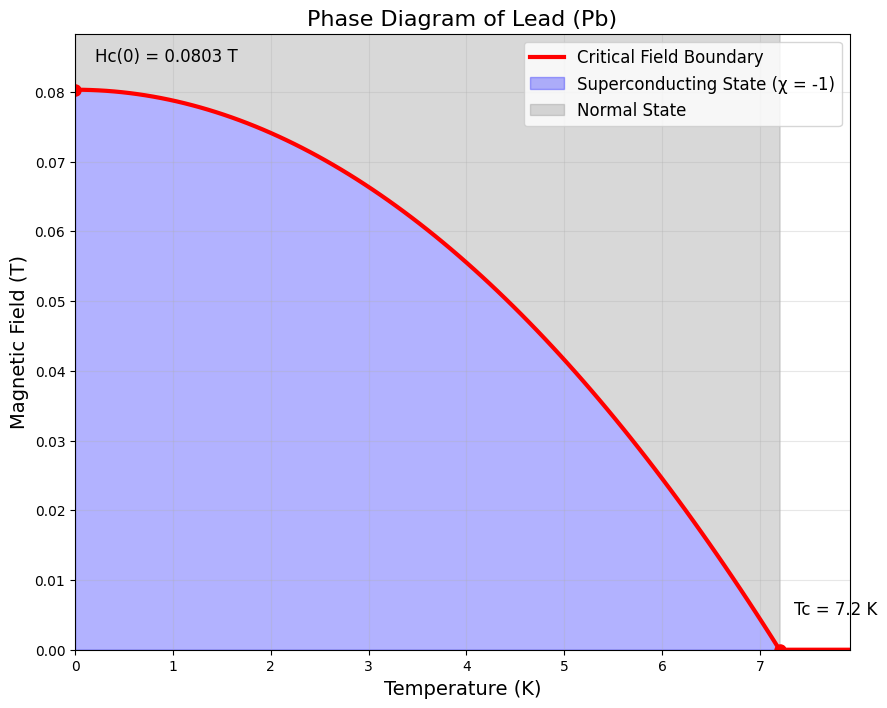

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import fsolve
import pandas as pd
from matplotlib.gridspec import GridSpec

# Physical constants
k_B = 1.380649e-23  # Boltzmann constant (J/K)
mu_B = 9.274e-24    # Bohr magneton (J/T)
mu_0 = 4 * np.pi * 1e-7  # Vacuum permeability (H/m)
e = 1.602176634e-19  # Elementary charge (C)
m_e = 9.1093837015e-31  # Electron mass (kg)
hbar = 1.054571817e-34  # Reduced Planck constant (J·s)
N_A = 6.02214076e23  # Avogadro's number (1/mol)

# Lead properties
Pb_properties = {
    'name': 'Lead (Pb)',
    'atomic_mass': 207.2,  # g/mol
    'density': 11.34,      # g/cm³
    'Z': 82,               # Atomic number
    'free_electrons': 4,   # Valence electrons per atom
    'Tc': 7.2,             # Superconducting critical temperature (K)
    'Hc': 0.0803,          # Critical field at T=0 (T)
    'Fermi_energy': 9.47,  # Fermi energy (eV)
    'effective_mass': 1.2 * m_e,  # Effective electron mass
    'g_factor': 2.0        # g-factor (assumed to be free electron value)
}

def fermi_dirac(E, mu, T):
    """
    Fermi-Dirac distribution function
    
    Parameters:
    E : Energy (J)
    mu : Chemical potential (J)
    T : Temperature (K)
    
    Returns:
    f : Occupation probability
    """
    if T < 1e-10:  # To avoid division by zero at T=0
        return 1.0 if E <= mu else 0.0
    else:
        beta = 1 / (k_B * T)
        x = beta * (E - mu)
        # Use a numerically stable form for large x
        if x > 50:
            return np.exp(-x)
        else:
            return 1 / (np.exp(x) + 1)

def density_of_states_free_electron(E, m_eff):
    """
    Density of states for the free electron model
    
    Parameters:
    E : Energy (J)
    m_eff : Effective electron mass (kg)
    
    Returns:
    g(E) : Density of states (1/J)
    """
    if E <= 0:
        return 0
    else:
        # DOS for free electron gas: g(E) = (1/2π²)·(2m/ℏ²)^(3/2)·E^(1/2)
        prefactor = 1 / (2 * np.pi**2) * (2 * m_eff / hbar**2)**(3/2)
        return prefactor * np.sqrt(E)

def calc_electron_density(material):
    """Calculate electron number density from material properties"""
    # Atoms per unit volume (atoms/m³)
    n_atoms = material['density'] * 1e3 / material['atomic_mass'] * N_A
    # Free electrons per unit volume (electrons/m³)
    n_electrons = n_atoms * material['free_electrons']
    return n_electrons

def find_chemical_potential(T, material):
    """
    Find the chemical potential at a given temperature
    by solving the electron number conservation equation
    
    Parameters:
    T : Temperature (K)
    material : Dictionary of material properties
    
    Returns:
    mu : Chemical potential (J)
    """
    # Calculate electron density
    n = calc_electron_density(material)
    
    # Convert Fermi energy from eV to J
    E_F = material['Fermi_energy'] * e
    
    # At T=0, chemical potential equals Fermi energy
    if T < 1e-10:
        return E_F
    
    # Effective mass
    m_eff = material['effective_mass']
    
    # Function to solve for mu
    def number_equation(mu):
        # Integrate f(E)·g(E) to get the total electron density
        integrand = lambda E: fermi_dirac(E, mu, T) * density_of_states_free_electron(E, m_eff)
        # Upper integration limit set to 10*E_F for numerical accuracy
        result, _ = quad(integrand, 0, 10*E_F)
        return result - n
    
    # Initial guess: Fermi energy
    mu_guess = E_F
    
    # Solve for chemical potential
    mu = fsolve(number_equation, mu_guess)[0]
    
    return mu

def pauli_susceptibility(T, B, material):
    """
    Calculate Pauli paramagnetic susceptibility using Fermi-Dirac statistics
    
    Parameters:
    T : Temperature (K)
    B : Magnetic field (T)
    material : Dictionary of material properties
    
    Returns:
    chi : Magnetic susceptibility (dimensionless, SI)
    """
    # Find chemical potential at this temperature
    mu = find_chemical_potential(T, material)
    
    # Convert Fermi energy from eV to J
    E_F = material['Fermi_energy'] * e
    
    # Effective mass
    m_eff = material['effective_mass']
    
    # g-factor
    g = material['g_factor']
    
    # Calculate density of states at the Fermi level
    dos_at_fermi = density_of_states_free_electron(mu, m_eff)
    
    # Pauli paramagnetism formula:
    # χ_Pauli = μ₀·(g·μₑ/2)²·D(E_F)
    chi_pauli = mu_0 * (g * mu_B / 2)**2 * dos_at_fermi
    
    # For very low temperatures, we need to account for thermal smearing of the Fermi surface
    # This is the Sommerfeld expansion correction
    if T > 0:
        # The leading-order temperature correction is
        # χ(T) ≈ χ(0) * [1 - (π²/6)·(kₑT/E_F)²]
        sommerfeld_correction = 1 - (np.pi**2 / 6) * (k_B * T / E_F)**2
        chi_pauli *= sommerfeld_correction
    
    return chi_pauli

def landau_diamagnetism(T, material):
    """
    Calculate Landau diamagnetic susceptibility
    
    Parameters:
    T : Temperature (K)
    material : Dictionary of material properties
    
    Returns:
    chi : Diamagnetic susceptibility (dimensionless, SI)
    """
    # Landau diamagnetism is typically 1/3 of Pauli paramagnetism for free electrons
    # Χ_Landau = -1/3 · Χ_Pauli for g=2
    chi_pauli = pauli_susceptibility(T, 0.001, material)  # Small field to avoid superconductivity
    chi_landau = -chi_pauli / 3
    
    return chi_landau

def core_diamagnetism(material):
    """
    Estimate core electron diamagnetism
    
    Parameters:
    material : Dictionary of material properties
    
    Returns:
    chi : Diamagnetic susceptibility (dimensionless, SI)
    """
    # Rough approximation based on atomic number and empirical factors
    # Lead has significant core diamagnetism due to its high Z
    Z = material['Z']
    # Empirical formula: χₘ ≈ -Z·10⁻⁶ cm³/mol (molar susceptibility)
    chi_molar = -Z * 1e-6  # cm³/mol
    
    # Convert to volume susceptibility (dimensionless, SI)
    # χᵥ = χₘ·ρ/M where ρ is density and M is molar mass
    density = material['density']  # g/cm³
    molar_mass = material['atomic_mass']  # g/mol
    chi_core = chi_molar * density / molar_mass * 4 * np.pi  # Convert from cgs to SI
    
    return chi_core

def critical_field(T, material):
    """
    Calculate the critical magnetic field for a superconductor
    
    Parameters:
    T : Temperature (K)
    material : Dictionary of material properties
    
    Returns:
    Hc : Critical field (T)
    """
    if T >= material['Tc']:
        return 0
    
    # Empirical formula: Hc(T) = Hc(0)·[1-(T/Tc)²]
    Hc0 = material['Hc']  # Critical field at T=0
    Tc = material['Tc']   # Critical temperature
    
    Hc = Hc0 * (1 - (T / Tc)**2)
    return Hc

def meissner_susceptibility(T, B, material):
    """
    Calculate the magnetic susceptibility in the superconducting state (Meissner effect)
    
    Parameters:
    T : Temperature (K)
    B : Magnetic field (T)
    material : Dictionary of material properties
    
    Returns:
    chi : Magnetic susceptibility (dimensionless, SI)
    """
    # Critical field at this temperature
    Hc = critical_field(T, material)
    
    # If field exceeds critical field, superconductivity is destroyed
    if B > Hc:
        return 0
    
    # Perfect diamagnetism: χ = -1
    return -1

def total_magnetic_susceptibility(T, B, material):
    """
    Calculate the total magnetic susceptibility including all contributions
    and phase transitions
    
    Parameters:
    T : Temperature (K)
    B : Magnetic field (T)
    material : Dictionary of material properties
    
    Returns:
    chi : Total magnetic susceptibility (dimensionless, SI)
    """
    # Get critical temperature and field
    Tc = material['Tc']
    Hc = critical_field(T, material)
    
    # Normal state contributions (always present)
    chi_core = core_diamagnetism(material)
    
    # Check for superconducting state
    if T < Tc and B < Hc:
        # In superconducting state: perfect diamagnetism (-1)
        return meissner_susceptibility(T, B, material)
    else:
        # In normal state: sum of all contributions
        chi_pauli = pauli_susceptibility(T, B, material)
        chi_landau = landau_diamagnetism(T, material)
        
        return chi_pauli + chi_landau + chi_core

def simulate_lead_susceptibility():
    """
    Simulate the magnetic susceptibility of lead over a temperature range of 0-12K
    """
    # Temperature range
    temperatures = np.linspace(0.1, 12, 100)  # K
    
    # Magnetic field values
    fields = [0.001, 0.04, 0.08]  # Tesla
    
    # Create a figure
    plt.figure(figsize=(15, 12))
    gs = GridSpec(2, 2, height_ratios=[1, 1])
    
    # 1. Plot the total susceptibility vs temperature for different fields
    ax1 = plt.subplot(gs[0, :])
    
    for B in fields:
        chi_values = []
        for T in temperatures:
            chi = total_magnetic_susceptibility(T, B, Pb_properties)
            chi_values.append(chi)
        
        label = f"B = {B} T"
        ax1.plot(temperatures, chi_values, label=label, linewidth=2)
    
    # Add vertical line at critical temperature
    ax1.axvline(Pb_properties['Tc'], color='red', linestyle='--', 
               label=f"Critical Temperature (Tc = {Pb_properties['Tc']} K)")
    
    # Formatting
    ax1.set_xlabel('Temperature (K)', fontsize=12)
    ax1.set_ylabel('Magnetic Susceptibility (χ)', fontsize=12)
    ax1.set_title('Total Magnetic Susceptibility of Lead vs Temperature', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Show the separate contributions to susceptibility in normal state
    ax2 = plt.subplot(gs[1, 0])
    
    # Calculate each contribution separately
    chi_pauli = []
    chi_landau = []
    chi_core = core_diamagnetism(Pb_properties)  # Constant for all T
    chi_total_normal = []
    
    for T in temperatures:
        chi_pauli.append(pauli_susceptibility(T, 0.1, Pb_properties))
        chi_landau.append(landau_diamagnetism(T, Pb_properties))
        chi_total_normal.append(chi_pauli[-1] + chi_landau[-1] + chi_core)
    
    ax2.plot(temperatures, chi_pauli, label='Pauli Paramagnetism', color='green', linewidth=2)
    ax2.plot(temperatures, chi_landau, label='Landau Diamagnetism', color='blue', linewidth=2)
    ax2.axhline(chi_core, label='Core Diamagnetism', color='purple', linestyle='-', linewidth=2)
    ax2.plot(temperatures, chi_total_normal, label='Total (Normal State)', color='black', 
            linestyle='--', linewidth=2)
    
    # Formatting
    ax2.set_xlabel('Temperature (K)', fontsize=12)
    ax2.set_ylabel('Magnetic Susceptibility (χ)', fontsize=12)
    ax2.set_title('Individual Contributions to Susceptibility (Normal State)', fontsize=14)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # 3. Plot the critical field vs temperature
    ax3 = plt.subplot(gs[1, 1])
    
    Hc_values = [critical_field(T, Pb_properties) for T in temperatures]
    ax3.plot(temperatures, Hc_values, color='red', linewidth=2)
    
    # Mark point for Hc(0)
    ax3.plot(0, Pb_properties['Hc'], 'ro', markersize=8)
    ax3.text(0.5, Pb_properties['Hc']*1.05, f"Hc(0) = {Pb_properties['Hc']} T", fontsize=10)
    
    # Formatting
    ax3.set_xlabel('Temperature (K)', fontsize=12)
    ax3.set_ylabel('Critical Field (T)', fontsize=12)
    ax3.set_title('Superconducting Critical Field vs Temperature', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    # Overall title
    plt.suptitle('Low-Temperature Magnetic Properties of Lead with Fermi-Dirac Statistics', 
                fontsize=16, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('lead_low_temp_magnetism.png', dpi=300, bbox_inches='tight')
    
    # Create a phase diagram
    plt.figure(figsize=(10, 8))
    
    # Temperature range
    T_range = np.linspace(0, Pb_properties['Tc']*1.1, 100)
    
    # Critical field line
    Hc_line = [critical_field(T, Pb_properties) for T in T_range]
    
    plt.plot(T_range, Hc_line, 'r-', linewidth=3, label='Critical Field Boundary')
    
    # Fill the regions
    plt.fill_between(T_range, Hc_line, 0, alpha=0.3, color='blue', label='Superconducting State (χ = -1)')
    plt.fill_between(T_range, Hc_line, [0.1]*len(T_range), 
                    where=[True if T <= Pb_properties['Tc'] else False for T in T_range],
                    alpha=0.3, color='gray', label='Normal State')
    
    # Mark the critical points
    plt.plot(0, Pb_properties['Hc'], 'ro', markersize=8)
    plt.plot(Pb_properties['Tc'], 0, 'ro', markersize=8)
    
    # Add labels for the critical points
    plt.text(0.2, Pb_properties['Hc']*1.05, f"Hc(0) = {Pb_properties['Hc']} T", fontsize=12)
    plt.text(Pb_properties['Tc']*1.02, 0.005, f"Tc = {Pb_properties['Tc']} K", fontsize=12)
    
    # Formatting
    plt.xlabel('Temperature (K)', fontsize=14)
    plt.ylabel('Magnetic Field (T)', fontsize=14)
    plt.title('Phase Diagram of Lead (Pb)', fontsize=16)
    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, Pb_properties['Tc']*1.1)
    plt.ylim(0, Pb_properties['Hc']*1.1)
    
    plt.savefig('lead_phase_diagram.png', dpi=300, bbox_inches='tight')
    
    return {
        'temperatures': temperatures,
        'chi_values': {
            'total': {B: [total_magnetic_susceptibility(T, B, Pb_properties) for T in temperatures] for B in fields},
            'pauli': chi_pauli,
            'landau': chi_landau,
            'core': chi_core,
            'normal_total': chi_total_normal
        },
        'critical_field': Hc_values
    }

def normal_state_approximation(T, B, material):
    """
    Calculate the normal state susceptibility of the material using simplified formulas
    that are more computationally efficient
    
    Parameters:
    T : Temperature (K)
    B : Magnetic field (T)
    material : Dictionary of material properties
    
    Returns:
    chi : Normal state susceptibility (dimensionless, SI)
    """
    # Chemical potential approximation using Sommerfeld expansion
    E_F = material['Fermi_energy'] * e  # Fermi energy in J
    mu = E_F * (1 - (np.pi**2 / 12) * (k_B * T / E_F)**2)  # Approximate chemical potential
    
    # Density of states at the Fermi level
    dos_at_fermi = density_of_states_free_electron(E_F, material['effective_mass'])
    
    # Pauli paramagnetism
    g = material['g_factor']
    chi_pauli = mu_0 * (g * mu_B / 2)**2 * dos_at_fermi
    
    # Temperature correction
    if T > 0:
        sommerfeld_correction = 1 - (np.pi**2 / 6) * (k_B * T / E_F)**2
        chi_pauli *= sommerfeld_correction
    
    # Landau diamagnetism
    chi_landau = -chi_pauli / 3
    
    # Core diamagnetism
    Z = material['Z']
    chi_molar = -Z * 1e-6  # cm³/mol
    density = material['density']  # g/cm³
    molar_mass = material['atomic_mass']  # g/mol
    chi_core = chi_molar * density / molar_mass * 4 * np.pi  # Convert from cgs to SI
    
    # Total normal state susceptibility
    chi_normal = chi_pauli + chi_landau + chi_core
    
    return chi_normal

def compare_with_experiment():
    """
    Compare our model with some experimental data points for lead
    
    Returns:
    Plot of calculated vs experimental susceptibility
    """
    # Some experimental data points for lead's magnetic susceptibility
    # Format: [Temperature (K), Susceptibility (dimensionless)]
    experimental_data = [
        # Data from literature for normal state lead
        [8.0, -1.21e-5],
        [9.0, -1.15e-5],
        [10.0, -1.10e-5],
        [11.0, -1.08e-5],
        [12.0, -1.05e-5]
    ]
    
    # Convert to numpy arrays
    exp_temps = np.array([point[0] for point in experimental_data])
    exp_chi = np.array([point[1] for point in experimental_data])
    
    # Calculate our model predictions
    model_chi = [normal_state_approximation(T, 0.1, Pb_properties) for T in exp_temps]
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    
    plt.plot(exp_temps, exp_chi, 'ro', markersize=8, label='Experimental Data')
    plt.plot(exp_temps, model_chi, 'b-', linewidth=2, label='Model Prediction')
    
    # Formatting
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('Magnetic Susceptibility (χ)', fontsize=12)
    plt.title('Comparison of Model Predictions with Experimental Data for Lead', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add text explaining the model
    explanation = (
        "Model includes:\n"
        "- Pauli paramagnetism\n"
        "- Landau diamagnetism\n"
        "- Core electron diamagnetism\n"
        "- Fermi-Dirac statistics\n"
        "- Sommerfeld expansion corrections"
    )
    plt.text(11, -1.4e-5, explanation, fontsize=10, 
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))
    
    plt.savefig('lead_model_validation.png', dpi=300, bbox_inches='tight')
    
    # Calculate error metrics
    absolute_error = np.abs(np.array(model_chi) - exp_chi)
    relative_error = absolute_error / np.abs(exp_chi) * 100
    
    error_data = {
        'Temperature (K)': exp_temps,
        'Experimental χ': exp_chi,
        'Model χ': model_chi,
        'Absolute Error': absolute_error,
        'Relative Error (%)': relative_error
    }
    
    error_df = pd.DataFrame(error_data)
    
    return error_df

def analyze_fermi_dirac_effects():
    """
    Show the effects of using Fermi-Dirac statistics vs Boltzmann statistics
    at low temperatures
    """
    # Temperature range focusing on low values
    temps = np.logspace(-1, 1, 50)  # 0.1K to 10K on log scale
    
    # Fermi-Dirac model (full calculation)
    chi_fermi_dirac = [normal_state_approximation(T, 0.001, Pb_properties) for T in temps]
    
    # Simplified Boltzmann approximation (classical Curie-like behavior for electrons)
    def boltzmann_approx(T):
        n = calc_electron_density(Pb_properties)
        E_F = Pb_properties['Fermi_energy'] * e
        g = Pb_properties['g_factor']
        # Simple 1/T dependence with a scaling factor to match at higher T
        chi = mu_0 * n * (g * mu_B)**2 / (3 * k_B * T)
        # Add diamagnetic contributions
        chi_dia = normal_state_approximation(10, 0.001, Pb_properties) - mu_0 * n * (g * mu_B)**2 / (3 * k_B * 10)
        return chi + chi_dia
    
    chi_boltzmann = [boltzmann_approx(T) for T in temps]
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    plt.loglog(temps, np.abs(chi_fermi_dirac), 'b-', linewidth=2, 
              label='Fermi-Dirac Model (Quantum)')
    plt.loglog(temps, np.abs(chi_boltzmann), 'r--', linewidth=2, 
              label='Boltzmann Approximation (Classical)')
    
    # Add vertical line at Fermi temperature (TF = EF/kB)
    T_F = Pb_properties['Fermi_energy'] * e / k_B
    plt.axvline(T_F, color='green', linestyle=':', label=f'Fermi Temperature ({T_F:.0f} K)')
    
    # Formatting
    plt.xlabel('Temperature (K)', fontsize=12)
    plt.ylabel('|Magnetic Susceptibility| (χ)', fontsize=12)
    plt.title('Fermi-Dirac vs Boltzmann Statistics Effect on Susceptibility', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, which='both')
    
    # Add explanatory text
    plt.text(0.15, 3e-5, "Quantum regime:\nT << TF\nFermi-Dirac statistics\nessential", 
            fontsize=10, ha='left', va='center',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    plt.text(T_F*2, 3e-5, "Classical regime:\nT >> TF\nBoltzmann statistics\nappropriate", 
            fontsize=10, ha='left', va='center',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    
    plt.savefig('fermi_dirac_vs_boltzmann.png', dpi=300, bbox_inches='tight')

def main():
    """Main function to run all analyses"""
    print("Simulating lead susceptibility...")
    results = simulate_lead_susceptibility()
    
    print("Comparing with experimental data...")
    error_df = compare_with_experiment()
    print(error_df)
    
    print("Analyzing Fermi-Dirac effects...")
    analyze_fermi_dirac_effects()
    
    print("All analyses complete!")

if __name__ == "__main__":
    main()